In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting Started with Claude 3 Models
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/generative_ai/anthropic_claude_3_intro.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fblob%2Fmain%2Fnotebooks%2Fofficial%2Fgenerative_ai%2Fanthropic_claude_3_intro.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td> 
  <td style="text-align: center">                                                                             
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/generative_ai/anthropic_claude_3_intro.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/generative_ai/anthropic_claude_3_intro.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  
</table>

## Overview

### Claude on Vertex AI

Anthropic Claude 3 models on Vertex AI offer fully managed and serverless models are offered as managed APIs. To use a Claude model on Vertex AI, send a request directly to the Vertex AI API endpoint.

You can stream your Claude responses to reduce the end-user latency perception. A streamed response uses server-sent events (SSE) to incrementally stream the response.

### Available Anthropic Claude models

#### Claude 3 Sonnet
Anthropic Claude 3 Sonnet provides a balance between intelligence and speed for enterprise workloads. It's a high-endurance model for scaled AI that's available at a competitive price.

#### Claude 3 Haiku
Anthropic Claude 3 Haiku is the fastest, most compact model available from Anthropic. It is designed to answer simple queries and requests quickly. You can use it to build AI experiences that mimic human interactions.

All Claude 3 models can process images and return text outputs, and feature a 200K context window.

## Objective

This notebook shows how to use **Vertex AI API** and **Anthropic’s Vertex SDK for Python** to call the Claude on Vertex AI API with the Claude 3 Sonnet and Claude 3 Haiku model.

For more information, see the [Use Claude](https://cloud.google.com/vertex-ai/generative-ai/docs/partner-models/use-claude) documentation.


## Vertex AI API

## Getting Started


### Install required packages


In [ ]:
! pip3 install -U -q httpx

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [ ]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

Authenticate your environment on Google Colab.


In [ ]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

#### Select Claude 3 model

In [ ]:
MODEL = "claude-3-sonnet@20240229"  # @param ["claude-3-sonnet@20240229", "claude-3-haiku@20240307", "claude-3-opus@20240229"]
if MODEL == "claude-3-sonnet@20240229":
    available_regions = ["us-central1", "asia-southeast1"]
elif MODEL == "claude-3-haiku@20240307":
    available_regions = ["us-central1", "europe-west4"]
else:
    available_regions = ["us-east5"]

#### Select a location

In [ ]:
import ipywidgets as widgets
from IPython.display import display

dropdown = widgets.Dropdown(
    options=available_regions,
    description="Select a location:",
    font_weight="bold",
    style={"description_width": "initial"},
)


def dropdown_eventhandler(change):
    global LOCATION
    if change["type"] == "change" and change["name"] == "value":
        LOCATION = change.new
        print("Selected:", change.new)


LOCATION = dropdown.value
dropdown.observe(dropdown_eventhandler, names="value")
display(dropdown)

#### Define Google Cloud project and model information

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
ENDPOINT = f"https://{LOCATION}-aiplatform.googleapis.com"

if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    raise ValueError("Please set your PROJECT_ID")

#### Import required libraries

In [ ]:
import json
import base64

import httpx
import requests
from IPython.display import Image

### Text generation

#### Unary call

Sends a POST request to the specified API endpoint to get a response from the model for a banana bread recipe using the provided payload.

In [ ]:
PAYLOAD = {
    "anthropic_version": "vertex-2023-10-16",
    "messages": [{"role": "user", "content": "Send me a recipe for banana bread."}],
    "max_tokens": 100,
    "stream": False,
}

request = json.dumps(PAYLOAD)
!curl -X POST -H "Authorization: Bearer $(gcloud auth print-access-token)" -H "Content-Type: application/json" {ENDPOINT}/v1/projects/{PROJECT_ID}/locations/{LOCATION}/publishers/anthropic/models/{MODEL}:rawPredict -d '{request}'

#### Streaming call

Sends a POST request to the specified API endpoint to stream a response from the model for a banana bread recipe using the provided payload.

In [ ]:
PAYLOAD = {
    "anthropic_version": "vertex-2023-10-16",
    "messages": [{"role": "user", "content": "Send me a recipe for banana bread."}],
    "max_tokens": 100,
    "stream": True,
}

request = json.dumps(PAYLOAD)
!curl -X POST -H "Authorization: Bearer $(gcloud auth print-access-token)" -H "Content-Type: application/json" {ENDPOINT}/v1/projects/{PROJECT_ID}/locations/{LOCATION}/publishers/anthropic/models/{MODEL}:streamRawPredict -d '{request}'

### Vision

#### Encode And Preview Image

We'll fetch sample images from Wikipedia using the httpx library, but you can use whatever image sources work for you.

In [ ]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a7/Camponotus_flavomarginatus_ant.jpg/300px-Camponotus_flavomarginatus_ant.jpg"
image_b64 = base64.b64encode(httpx.get(image_url).content).decode("utf-8")

response = requests.get(image_url)
image = Image(response.content, width=300, height=200)

image

#### Unary call

Sends a POST request to the specified API endpoint to get a response from the model analyzing the content of an image, provided as base64-encoded data, along with the text prompt.

In [ ]:
PAYLOAD = {
    "anthropic_version": "vertex-2023-10-16",
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": image_b64,
                    },
                },
                {"type": "text", "text": "What is in this image?"},
            ],
        }
    ],
    "max_tokens": 100,
    "stream": False,
}

request = json.dumps(PAYLOAD)
!curl -X POST -H "Authorization: Bearer $(gcloud auth print-access-token)" -H "Content-Type: application/json" {ENDPOINT}/v1/projects/{PROJECT_ID}/locations/{LOCATION}/publishers/anthropic/models/{MODEL}:rawPredict -d '{request}'

#### Streaming call

Sends a POST request to the specified API endpoint to stream a response from the model analyzing the content of an image, provided as base64-encoded data, along with the text prompt.

In [ ]:
PAYLOAD = {
    "anthropic_version": "vertex-2023-10-16",
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": image_b64,
                    },
                },
                {"type": "text", "text": "What is in this image?"},
            ],
        }
    ],
    "max_tokens": 100,
    "stream": True,
}

request = json.dumps(PAYLOAD)
!curl -X POST -H "Authorization: Bearer $(gcloud auth print-access-token)" -H "Content-Type: application/json" {ENDPOINT}/v1/projects/{PROJECT_ID}/locations/{LOCATION}/publishers/anthropic/models/{MODEL}:streamRawPredict -d '{request}'

## Using Anthropic's Vertex SDK for *Python*

## Getting Started


### Install Anthropic's Vertex SDK and other required packages

In [2]:
! pip3 install -U -q 'anthropic[vertex]'
! pip3 install -U -q httpx

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import sys

if "google.colab" in sys.modules:
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

Authenticate your environment on Google Colab.


In [ ]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

#### Select Claude 3 model

In [3]:
MODEL = "claude-3-sonnet@20240229"  # @param ["claude-3-sonnet@20240229", "claude-3-haiku@20240307", "claude-3-opus@20240229"]
if MODEL == "claude-3-sonnet@20240229":
    available_regions = ["us-central1", "asia-southeast1"]
elif MODEL == "claude-3-haiku@20240307":
    available_regions = ["us-central1", "europe-west4"]
else:
    available_regions = ["us-east5"]

#### Select a region

In [4]:
import ipywidgets as widgets
from IPython.display import display

dropdown = widgets.Dropdown(
    options=available_regions,
    description="Select a location:",
    font_weight="bold",
    style={"description_width": "initial"},
)


def dropdown_eventhandler(change):
    global LOCATION
    if change["type"] == "change" and change["name"] == "value":
        LOCATION = change.new
        print("Selected:", change.new)


LOCATION = dropdown.value
dropdown.observe(dropdown_eventhandler, names="value")
display(dropdown)

Dropdown(description='Select a location:', options=('us-central1', 'europe-west4'), style=DescriptionStyle(des…

#### Define Google Cloud project and model information

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).#### Define Google Cloud project and model information

In [5]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
ENDPOINT = f"https://{LOCATION}-aiplatform.googleapis.com"

if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    raise ValueError("Please set your PROJECT_ID")

#### Import required libraries

In [6]:
import base64

import httpx
import requests
from IPython.display import Image

### Text generation

#### Unary call

Initializes a client for Anthropic's Vertex AI, sends a request to generate the content, and prints the response in a formatted JSON

In [7]:
from anthropic import AnthropicVertex

client = AnthropicVertex(region=LOCATION, project_id=PROJECT_ID)
message = client.messages.create(
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": "Send me a recipe for banana bread.",
        }
    ],
    model=MODEL,
)
print(message.model_dump_json(indent=2))

{
  "id": "msg_vrtx_01217PxzvULUjECXyvq8Y64n",
  "content": [
    {
      "text": "Here is a classic recipe for moist and delicious banana bread:\n\nBanana Bread\n\nIngredients:\n- 1 3/4 cups (220g) all-purpose flour \n- 1 teaspoon baking soda\n- 1/4 teaspoon salt\n- 1/2 cup (115g) unsalted butter, softened\n- 3/4 cup (150g) granulated sugar\n- 2 large eggs\n- 1 teaspoon vanilla extract\n- 1 1/4 cups (300g) mashed ripe bananas (about 3 medium bananas)\n\nInstructions:\n\n1. Preheat the oven to 350\u00b0F (177\u00b0C). Grease a 9x5-inch loaf pan or line it with parchment paper.\n\n2. In a medium bowl, whisk together the flour, baking soda, and salt. Set aside.\n\n3. In a large bowl, beat the butter and sugar together until light and fluffy, about 2-3 minutes. Beat in the eggs one at a time, then stir in the vanilla and mashed bananas until combined.\n\n4. Fold the dry ingredients into the wet ingredients until just combined. Do not overmix.\n\n5. Pour the batter into the prepared loaf p

#### Streaming call

Initializes a client for Anthropic's Vertex AI, sends a streaming request to generate the content, and continuously prints the received text as it is streamed.

In [8]:
from anthropic import AnthropicVertex

client = AnthropicVertex(region=LOCATION, project_id=PROJECT_ID)

with client.messages.stream(
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": "Send me a recipe for banana bread.",
        }
    ],
    model=MODEL,
) as stream:
    for text in stream.text_stream:
        print(text, end="", flush=True)

Here is a classic recipe for moist and delicious banana bread:

Banana Bread

Ingredients:
- 1 3/4 cups all-purpose flour 
- 1 teaspoon baking soda
- 1/4 teaspoon salt
- 1/2 cup unsalted butter, softened
- 3/4 cup granulated sugar
- 2 large eggs
- 1 teaspoon vanilla extract
- 1 1/4 cups mashed ripe bananas (about 3 medium bananas)

Instructions:

1. Preheat oven to 350°F. Grease a 9x5 inch loaf pan.

2. In a medium bowl, whisk together the flour, baking soda and salt. Set aside.

3. In a large bowl, beat the butter and sugar together until light and fluffy, about 2-3 minutes. Beat in the eggs one at a time, then stir in the vanilla and mashed bananas until combined. 

4. Fold the dry ingredients into the wet ingredients until just combined, being careful not to overmix.

5. Pour the batter into the prepared loaf pan. Bake for 55-65 minutes, until a toothpick inserted in the center comes out clean. 

6. Allow the banana bread to cool in the pan for 10 minutes, then transfer to a wire ra

### Vision

#### Encode And Preview Image

We'll fetch sample images from Wikipedia using the httpx library, but you can use whatever image sources work for you.

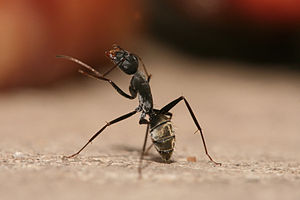

In [9]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a7/Camponotus_flavomarginatus_ant.jpg/300px-Camponotus_flavomarginatus_ant.jpg"
image_media_type = "image/jpeg"
image_b64 = base64.b64encode(httpx.get(image_url).content).decode("utf-8")

response = requests.get(image_url)
image = Image(response.content, width=300, height=200)

image

#### Unary call

Initializes a client for Anthropic's Vertex AI, sends a request to describe an image (provided as base64-encoded data) along with a text prompt, and prints the response in a formatted JSON.

In [10]:
from anthropic import AnthropicVertex

client = AnthropicVertex(region=LOCATION, project_id=PROJECT_ID)

message = client.messages.create(
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": image_media_type,
                        "data": image_b64,
                    },
                },
                {"type": "text", "text": "Describe this image."},
            ],
        }
    ],
    model=MODEL,
)
print(message.model_dump_json(indent=2))

{
  "id": "msg_vrtx_01XBoXC1Q3WaFRXhpzcQNSdQ",
  "content": [
    {
      "text": "This image depicts a close-up view of a small insect, likely an ant or similar crawling arthropod. The insect has a distinct segmented body, with a head, thorax, and abdomen visible. Its legs are extended and the creature appears to be in motion, possibly foraging or exploring its environment. The image is sharply focused, allowing for detailed observation of the insect's features, such as its antennae and compound eyes. The background is blurred, drawing the viewer's attention to the central subject of the image.",
      "type": "text"
    }
  ],
  "model": "claude-3-haiku-20240307",
  "role": "assistant",
  "stop_reason": "end_turn",
  "stop_sequence": null,
  "type": "message",
  "usage": {
    "input_tokens": 104,
    "output_tokens": 118
  }
}


#### Streaming call

Initializes a client for Anthropic's Vertex AI, sends a streaming request to describe an image (provided as base64-encoded data) along with a text prompt, and continuously prints the received text as it is streamed.

In [ ]:
from anthropic import AnthropicVertex

client = AnthropicVertex(region=LOCATION, project_id=PROJECT_ID)

with client.messages.stream(
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": image_media_type,
                        "data": image_b64,
                    },
                },
                {"type": "text", "text": "Describe this image."},
            ],
        }
    ],
    model=MODEL,
) as stream:
    for text in stream.text_stream:
        print(text, end="", flush=True)